In [1]:
pip install livelossplot

In [2]:
import tensorflow as tf
import glob
import os
import keras
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
# import shuffle
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from random import shuffle
from keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from keras.layers.normalization import BatchNormalization
%matplotlib inline

In [3]:
df=pd.read_csv("/content/loan_data.csv", header=0, dtype={
    'purpose': 'category',  # <--  
})
print(df)
print(dict(enumerate(df['purpose'].cat.categories)))

      credit.policy             purpose  ...  pub.rec  not.fully.paid
0                 1  debt_consolidation  ...        0               0
1                 1         credit_card  ...        0               0
2                 1  debt_consolidation  ...        0               0
3                 1  debt_consolidation  ...        0               0
4                 1         credit_card  ...        0               0
...             ...                 ...  ...      ...             ...
9573              0           all_other  ...        0               1
9574              0           all_other  ...        0               1
9575              0  debt_consolidation  ...        0               1
9576              0    home_improvement  ...        0               1
9577              0  debt_consolidation  ...        0               1

[9578 rows x 14 columns]
{0: 'all_other', 1: 'credit_card', 2: 'debt_consolidation', 3: 'educational', 4: 'home_improvement', 5: 'major_purchase', 6: 'small_bu

In [4]:
df = df.sample(frac=1)
# shuffled_df.to_csv(new_file_name, index=False)

In [5]:
paid_values=df.loc[df['not.fully.paid'] == 1]

In [6]:
print(paid_values)

      credit.policy             purpose  ...  pub.rec  not.fully.paid
8014              0  debt_consolidation  ...        0               1
804               1  debt_consolidation  ...        0               1
7704              1         educational  ...        0               1
4952              1      small_business  ...        0               1
2526              1           all_other  ...        0               1
...             ...                 ...  ...      ...             ...
5842              1    home_improvement  ...        0               1
8202              0      small_business  ...        0               1
4442              1         educational  ...        0               1
5127              1      small_business  ...        0               1
2756              1      major_purchase  ...        0               1

[1533 rows x 14 columns]


In [7]:
unpaid_values=df.loc[df['not.fully.paid'] == 0].head(1533)

In [8]:
print(unpaid_values)

      credit.policy             purpose  ...  pub.rec  not.fully.paid
3000              1         credit_card  ...        0               0
6626              1  debt_consolidation  ...        0               0
5028              1  debt_consolidation  ...        0               0
9054              0      small_business  ...        0               0
8184              0  debt_consolidation  ...        0               0
...             ...                 ...  ...      ...             ...
4539              1    home_improvement  ...        0               0
3318              1      major_purchase  ...        0               0
7445              1  debt_consolidation  ...        0               0
531               1  debt_consolidation  ...        0               0
6619              1  debt_consolidation  ...        0               0

[1533 rows x 14 columns]


In [9]:
df=paid_values.append(unpaid_values)
print(df)

      credit.policy             purpose  ...  pub.rec  not.fully.paid
8014              0  debt_consolidation  ...        0               1
804               1  debt_consolidation  ...        0               1
7704              1         educational  ...        0               1
4952              1      small_business  ...        0               1
2526              1           all_other  ...        0               1
...             ...                 ...  ...      ...             ...
4539              1    home_improvement  ...        0               0
3318              1      major_purchase  ...        0               0
7445              1  debt_consolidation  ...        0               0
531               1  debt_consolidation  ...        0               0
6619              1  debt_consolidation  ...        0               0

[3066 rows x 14 columns]


In [10]:
df = df.sample(frac=1)

In [11]:
print(df)

      credit.policy             purpose  ...  pub.rec  not.fully.paid
5352              1  debt_consolidation  ...        0               1
5593              1  debt_consolidation  ...        0               0
4978              1  debt_consolidation  ...        0               1
2205              1      small_business  ...        0               1
4836              1           all_other  ...        0               1
...             ...                 ...  ...      ...             ...
8562              0           all_other  ...        0               1
992               1  debt_consolidation  ...        0               0
7420              1  debt_consolidation  ...        0               0
7731              0           all_other  ...        0               0
9080              0         educational  ...        0               1

[3066 rows x 14 columns]


In [12]:
# dataset['split'] = np.random.randn(dataset.shape[0], 1)

msk = np.random.rand(len(df)) <= 0.7

train = df[msk]
test = df[~msk]

In [13]:
train_label=train.filter(["not.fully.paid"], axis=1)
test_label=test.filter(["not.fully.paid"], axis=1)
del train["not.fully.paid"]
del test["not.fully.paid"]

In [14]:
print(test)
print(test_label)

      credit.policy             purpose  ...  delinq.2yrs  pub.rec
4978              1  debt_consolidation  ...            0        0
4836              1           all_other  ...            0        0
5727              1           all_other  ...            0        0
7799              0         credit_card  ...            1        0
9049              0           all_other  ...            0        0
...             ...                 ...  ...          ...      ...
8685              0  debt_consolidation  ...            0        0
1066              1           all_other  ...            0        0
8714              0  debt_consolidation  ...            0        0
6786              1  debt_consolidation  ...            0        0
9080              0         educational  ...            0        0

[880 rows x 13 columns]
      not.fully.paid
4978               1
4836               1
5727               1
7799               1
9049               1
...              ...
8685               1
106

In [15]:
# train=np.array(train)
# print(train.shape)
# train_labels=train[0:-1, -1]
# print(train)
# print(train_labels)

In [16]:
# test=np.array(test)
# print(test.shape)
# test_labels=test[0:-1, -1]
# print(test)
# print(test_labels)

In [17]:
# train=np.delete(train, -1, axis=1)
# test=np.delete(test, -1, axis=1)

In [18]:
# print(train)
# print(test)

In [19]:
model=Sequential()
model.add(Dense(6, input_shape=(19, ), activation="relu", kernel_regularizer='l2'))
# model.add(BatchNormalization())

model.add(Dense(12, activation="relu"))
# model.add(Dropout(0.25))
# model.add(BatchNormalization())

model.add(Dense(32, activation="relu", kernel_regularizer='l2'))
model.add(Dropout(0.25))
# model.add(BatchNormalization())

model.add(Dense(64, activation="relu",  kernel_regularizer='l2')) #added kernal regularizer aand removed dropout
# model.add(Dropout(0.25))
# model.add(BatchNormalization())

model.add(Dense(128, activation="relu", kernel_regularizer='l2'))
# model.add(Dense(128, activation="relu", kernel_regularizer='l2'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Dense(256, activation="relu", kernel_regularizer='l2'))
model.add(Dense(2, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                416       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2

In [20]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [21]:
train = pd.get_dummies(train, columns=['purpose'])
print(train)

train_label=np.asarray(train_label).astype(np.float32)

      credit.policy  int.rate  ...  purpose_major_purchase  purpose_small_business
5352              1    0.0859  ...                       0                       0
5593              1    0.1218  ...                       0                       0
2205              1    0.1347  ...                       0                       1
993               1    0.0800  ...                       0                       0
8893              0    0.1726  ...                       0                       1
...             ...       ...  ...                     ...                     ...
9269              0    0.1739  ...                       0                       1
8562              0    0.1355  ...                       0                       0
992               1    0.1197  ...                       0                       0
7420              1    0.1099  ...                       0                       0
7731              0    0.1028  ...                       0                       0

[21

In [22]:
from sklearn import preprocessing
x = train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train = pd.DataFrame(x_scaled)

In [23]:
print(train)

       0         1         2         3         4   ...   14   15   16   17   18
0     1.0  0.165601  0.366135  0.362566  0.549399  ...  1.0  0.0  0.0  0.0  0.0
1     1.0  0.395141  0.349900  0.525791  0.363151  ...  1.0  0.0  0.0  0.0  0.0
2     1.0  0.477621  0.260428  0.396496  0.423231  ...  0.0  0.0  0.0  0.0  1.0
3     1.0  0.127877  0.060386  0.532915  0.418892  ...  0.0  0.0  0.0  0.0  0.0
4     0.0  0.719949  0.258895  0.426072  0.409212  ...  0.0  0.0  0.0  0.0  1.0
...   ...       ...       ...       ...       ...  ...  ...  ...  ...  ...  ...
2181  0.0  0.728261  0.378003  0.702369  0.360481  ...  0.0  0.0  0.0  0.0  1.0
2182  0.0  0.482737  0.207354  0.451982  0.865487  ...  0.0  0.0  0.0  0.0  0.0
2183  1.0  0.381714  0.060431  0.532915  0.498999  ...  1.0  0.0  0.0  0.0  0.0
2184  1.0  0.319054  0.108993  0.518313  0.021028  ...  1.0  0.0  0.0  0.0  0.0
2185  0.0  0.273657  0.163964  0.590131  0.333778  ...  0.0  0.0  0.0  0.0  0.0

[2186 rows x 19 columns]


In [24]:
train=np.asarray(train).astype(np.float32)

In [25]:
print(train.shape)
print(train_label)

(2186, 19)
[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


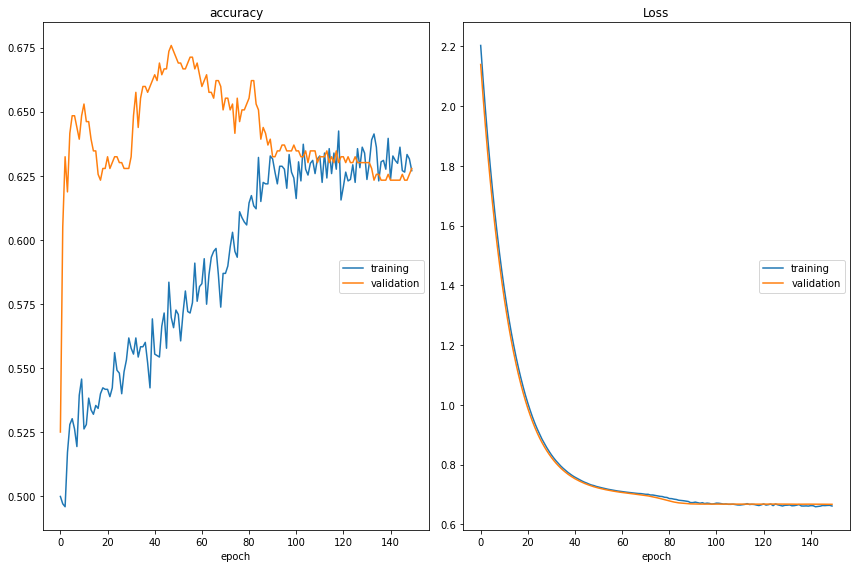

accuracy
	training         	 (min:    0.496, max:    0.642, cur:    0.627)
	validation       	 (min:    0.525, max:    0.676, cur:    0.628)
Loss
	training         	 (min:    0.659, max:    2.203, cur:    0.662)
	validation       	 (min:    0.667, max:    2.139, cur:    0.667)

Epoch 00150: val_loss did not improve from 0.66725
CPU times: user 1min 52s, sys: 18.1 s, total: 2min 10s
Wall time: 1min 48s


In [26]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, mode='min')

callbacks = [PlotLossesCallback(), chkpt]

model.fit(x=train, y=train_label, validation_split=0.2, batch_size=30, epochs=150, shuffle=False, verbose=2, callbacks=callbacks)

In [27]:
test = pd.get_dummies(test, columns=['purpose'])
print(test)

test_label=np.asarray(test_label).astype(np.float32)

      credit.policy  int.rate  ...  purpose_major_purchase  purpose_small_business
4978              1    0.1253  ...                       0                       0
4836              1    0.1287  ...                       0                       0
5727              1    0.1670  ...                       0                       0
7799              0    0.1691  ...                       0                       0
9049              0    0.2011  ...                       0                       0
...             ...       ...  ...                     ...                     ...
8685              0    0.0976  ...                       0                       0
1066              1    0.1229  ...                       0                       0
8714              0    0.1418  ...                       0                       0
6786              1    0.0859  ...                       0                       0
9080              0    0.1316  ...                       0                       0

[88

In [28]:
x = test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test = pd.DataFrame(x_scaled)

In [29]:
test=np.asarray(test).astype(np.float32)

In [30]:
prediction=model.predict(x=test)

In [31]:
print(prediction)

[[0.5588042  0.43526763]
 [0.48794526 0.50991094]
 [0.39718395 0.60557306]
 ...
 [0.41935465 0.5822325 ]
 [0.63141245 0.359207  ]
 [0.4004373  0.60214937]]


In [32]:
rounded_pred=np.round(prediction)
print(rounded_pred)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [33]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [34]:
cm=confusion_matrix(y_true=test_label, y_pred=np.argmax(rounded_pred, axis=-1))

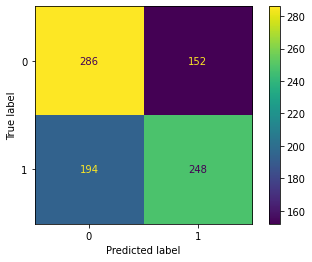

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp = disp.plot(values_format="")
plt.show()

In [36]:
print(test.shape)

(880, 19)


In [37]:
print(test_label.shape)

(880, 1)
